####Data Warngling Project

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import tweepy 
from tweepy import OAuthHandler
import json
import requests
import re
import os
import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from timeit import default_timer as timer


##install required libraries  
pip install tweepy

change os directory :
print(os.getcwd())
os.chdir('C:\Dola\Data warngel')
print(os.getcwd())

###First we will start with Data Ghatring 

1 - open twitter archive file csv with pandas

In [4]:
arch_df = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
arch_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


2 - open image predection file with requests 

In [6]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
file_name = url.split('/')[-1]
with open(file_name,'wb') as f:
    f.write(r.content)
file_name

'image-predictions.tsv'

In [7]:
image_df = pd.read_csv('image-predictions.tsv',sep='\t')
image_df.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


3 - query jason file 

In [8]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

NameError: name 'df_1' is not defined

In [ ]:
df_list = []
with open('tweet-json.txt','r') as file:
        for line in file:
            tweet = json.loads(line)
            tweet_id = tweet['id']
            retweet_count = tweet['retweet_count']
            fav_count = tweet['favorite_count']
            df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df_now = pd.DataFrame(df_list)
api_df_now.head(10)
api_df_now.to_csv('tweeter_data.csv', index = False )
tweet_df = pd.read_csv('tweeter_data.csv')
tweet_df.head(1)


###Second - Assessing Data

In [10]:
arch_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
arch_df.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [12]:
arch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
arch_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
arch_df.name.value_counts().head(50)

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Lola        10
Tucker      10
Penny       10
Winston      9
Bo           9
Sadie        8
the          8
Toby         7
Buddy        7
Bailey       7
Daisy        7
an           7
Leo          6
Bella        6
Dave         6
Rusty        6
Koda         6
Stanley      6
Oscar        6
Scout        6
Milo         6
Jack         6
Jax          6
Chester      5
George       5
Gus          5
Larry        5
very         5
Finn         5
Louis        5
Bentley      5
Phil         5
Sammy        5
Alfie        5
Sunny        5
Oakley       5
Duke         4
Scooter      4
Beau         4
Gerald       4
Boomer       4
Winnie       4
Dexter       4
Archie       4
Name: name, dtype: int64

In [15]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [16]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [18]:
image_df.img_num.describe()

count    2075.000000
mean        1.203855
std         0.561875
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: img_num, dtype: float64

In [19]:
tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [20]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [21]:
tweet_df.tail()

,tweet_id,retweet_count,favorite_count
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132
2353,666020888022790149,532,2535


Quality issuue 

Arch file :
* timestamp has +0000 
* timestamp to be changed to date time 
* retweeted_status_id have 181 record 
* in_reply_to_status_id have 78 record
* remove retweet & reply cloumns ( 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp')
* replace nan value with none in expanded_urls cloums 
* change tweet ID to str inestade of int


Image file :
* change tweet ID to str inestade of int
* we have 2356 record in twitter-archive-enhanced  and  2075 in image
* change P1 , p2 , p3 first litter to be upper case on all data  
* change header name to be full word ( p1 : prediction_1 , p2 : prediction_2 , p3 : prediction_3 , p1_conf : confidence_1 , p2_conf :confidence_2 , p3_conf : confidence_3 , p1_dog : dog_1 , p2_dog : dog_2 , p3_dog : dog_3 )


Tweeter File :
* change tweet ID to str inestade of int


Tidnees issuue 
* cocatenate dogs classfication in one cloumn
* adding three data frames in one file 


###Cleaning Data 

In [22]:
# First i will store data in new copy csv file 
#arch_df.to_csv('arch_df_copy.csv',index=False)
#image_df.to_csv('image_df_copy.csv',index=False)
#tweet_df.to_csv('tweet_df_copy.csv',index=False)
arch_clean_df = arch_df.copy()
image_clean_df = image_df.copy()
tweet_clean_df = tweet_df.copy

In [23]:
#image_clean_df = pd.read_csv('image_df_copy.csv')
#tweet_clean_df = pd.read_csv('tweet_df_copy.csv')

In [188]:
#arch_clean_df= pd.read_csv('arch_df_copy.csv')


Define: Tide
* 1 - cocatenate dogs_classfication in one cloumn 

Code

In [24]:
arch_clean_df['dogs_classfication'] = arch_clean_df['text'].str.extract('(doggo|floofer|pupper|puppo )')

In [25]:
arch_clean_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dogs_classfication
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,NaN


In [26]:
arch_clean_df.dogs_classfication.value_counts()

pupper     265
doggo       94
puppo       17
floofer      4
Name: dogs_classfication, dtype: int64

In [27]:
arch_clean_df = arch_clean_df.drop(columns=['pupper','doggo','puppo','floofer'])

Test

In [28]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  dogs_classfication          380 n

Define :

* 1 - remove +0000 in timestamp cloumn 

In [194]:
arch_clean_df.timestamp.head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

Code

In [195]:
arch_clean_df['timestamp'] = arch_df['timestamp'].str[:-5]
arch_clean_df['timestamp'].head()

0    2017-08-01 16:23:56 
1    2017-08-01 00:17:27 
2    2017-07-31 00:18:03 
3    2017-07-30 15:58:51 
4    2017-07-29 16:00:24 
Name: timestamp, dtype: object

Test 

In [196]:
arch_clean_df['timestamp'].head()

0    2017-08-01 16:23:56 
1    2017-08-01 00:17:27 
2    2017-07-31 00:18:03 
3    2017-07-30 15:58:51 
4    2017-07-29 16:00:24 
Name: timestamp, dtype: object

Define :

* 2 - change timestamp cloumn to date formate 

Code

In [197]:
arch_clean_df['timestamp'] = pd.to_datetime(arch_clean_df['timestamp'])

Test

In [198]:
arch_clean_df['timestamp'].astype

<bound method NDFrame.astype of 0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
               ...        
2351   2015-11-16 00:24:50
2352   2015-11-16 00:04:52
2353   2015-11-15 23:21:54
2354   2015-11-15 23:05:30
2355   2015-11-15 22:32:08
Name: timestamp, Length: 2356, dtype: datetime64[ns]>

Define:
* 3 - Remove retweeted_status_id have 181 record 
  

Code

In [199]:
arch_clean_df = arch_clean_df[arch_clean_df.retweeted_status_id.isnull()]

Test

In [200]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2175 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2175 non-null   datetime64[ns]
 4   source                      2175 non-null   object        
 5   text                        2175 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2117 non-null   object        
 10  rating_numerator            2175 non-null   int64         
 11  rating_denominator          2175 non-null   int64       

Define
* 4 - Remove in_reply_to_status_id have 78 record


Code

In [201]:
arch_clean_df = arch_clean_df[arch_clean_df.in_reply_to_status_id.isnull()]

Test

In [202]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2097 non-null   int64         
 1   in_reply_to_status_id       0 non-null      float64       
 2   in_reply_to_user_id         0 non-null      float64       
 3   timestamp                   2097 non-null   datetime64[ns]
 4   source                      2097 non-null   object        
 5   text                        2097 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2094 non-null   object        
 10  rating_numerator            2097 non-null   int64         
 11  rating_denominator          2097 non-null   int64       

Define :
* 5 - remove retweet & reply cloumns ('in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp')

Code

In [203]:
arch_clean_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'],axis=1,inplace=True)

Test

In [204]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   int64         
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2097 non-null   int64         
 6   rating_denominator  2097 non-null   int64         
 7   name                2097 non-null   object        
 8   dogs_classfication  339 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 163.8+ KB


Define:
* 6 - replace nan value with none in expanded_urls cloums 


Code

In [205]:
arch_clean_df= arch_clean_df[arch_clean_df.expanded_urls.notnull()]

Test

In [206]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2094 non-null   int64         
 1   timestamp           2094 non-null   datetime64[ns]
 2   source              2094 non-null   object        
 3   text                2094 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2094 non-null   int64         
 6   rating_denominator  2094 non-null   int64         
 7   name                2094 non-null   object        
 8   dogs_classfication  338 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 163.6+ KB


Define :
* 7 - change tweet_id to str inestade of int  


Code

In [207]:
arch_clean_df.tweet_id = arch_clean_df.tweet_id.astype('str')


Test

In [208]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2094 non-null   object        
 1   timestamp           2094 non-null   datetime64[ns]
 2   source              2094 non-null   object        
 3   text                2094 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2094 non-null   int64         
 6   rating_denominator  2094 non-null   int64         
 7   name                2094 non-null   object        
 8   dogs_classfication  338 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 163.6+ KB


Define : 
* 8 - change tweet ID to str inestade of int in image file 

Code

In [209]:
image_clean_df.head()
image_clean_df.tweet_id = image_clean_df.tweet_id.astype('str')

Test

In [210]:
image_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [211]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2094 non-null   object        
 1   timestamp           2094 non-null   datetime64[ns]
 2   source              2094 non-null   object        
 3   text                2094 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2094 non-null   int64         
 6   rating_denominator  2094 non-null   int64         
 7   name                2094 non-null   object        
 8   dogs_classfication  338 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 243.6+ KB


In [212]:
image_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


Define : 
* 9 - Remove tweets without image from archive file 

Code

In [219]:
tweets_with_image = list(image_clean_df.tweet_id.unique())
arch_clean_df = arch_clean_df[arch_clean_df.tweet_id.isin(tweets_with_image)]

Test

In [220]:
arch_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   name                1971 non-null   object        
 8   dogs_classfication  309 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 234.0+ KB


Define:
* 10 - change P1 , p2 , p3 first litter to be upper case on all data 


Code

In [226]:
image_clean_df.p1 = image_clean_df.p1.str.title()
image_clean_df.p2 = image_clean_df.p2.str.title()
image_clean_df.p3 = image_clean_df.p3.str.title()

Test

In [227]:
image_clean_df.p1.head()

0    Welsh_Springer_Spaniel
1                   Redbone
2           German_Shepherd
3       Rhodesian_Ridgeback
4        Miniature_Pinscher
Name: p1, dtype: object

In [228]:
image_clean_df.p2.head()

0                Collie
1    Miniature_Pinscher
2              Malinois
3               Redbone
4            Rottweiler
Name: p2, dtype: object

In [229]:
image_clean_df.p3.head()

0      Shetland_Sheepdog
1    Rhodesian_Ridgeback
2             Bloodhound
3     Miniature_Pinscher
4               Doberman
Name: p3, dtype: object

Define :
* 11 - change header name to be full word ( p1 : prediction_1 , p2 : prediction_2 , p3 : prediction_3 , p1_conf : confidence_1 , p2_conf :confidence_2 , p3_conf : confidence_3 , p1_dog : dog_1 , p2_dog : dog_2 , p3_dog : dog_3 ) 

Code

In [231]:
columns_correction = ['tweet_id','jpg_url','img_num','prediction_1','confidence_1','dog_1','prediction_2','confidence_2','dog_2','prediction_3','confidence_3','dog_3']
image_clean_df.columns = columns_correction

In [232]:
image_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      2075 non-null   object 
 1   jpg_url       2075 non-null   object 
 2   img_num       2075 non-null   int64  
 3   prediction_1  2075 non-null   object 
 4   confidence_1  2075 non-null   float64
 5   dog_1         2075 non-null   bool   
 6   prediction_2  2075 non-null   object 
 7   confidence_2  2075 non-null   float64
 8   dog_2         2075 non-null   bool   
 9   prediction_3  2075 non-null   object 
 10  confidence_3  2075 non-null   float64
 11  dog_3         2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


Define:
* 12 - change tweet ID to str inestade of int

Code

In [235]:
tweet_clean_df.info()
tweet_clean_df.tweet_id = tweet_clean_df.tweet_id.astype('str')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


Test

In [236]:
tweet_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


Define :

Concatente 3 data frames into one data frame

Code

In [237]:
data_merge = pd.merge(arch_clean_df,image_clean_df,on=['tweet_id'],how='left')

In [238]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   name                1971 non-null   object        
 8   dogs_classfication  309 non-null    object        
 9   jpg_url             1971 non-null   object        
 10  img_num             1971 non-null   int64         
 11  prediction_1        1971 non-null   object        
 12  confidence_1        1971 non-null   float64       
 13  dog_1               1971 non-null   bool        

In [239]:
data_merge = pd.merge(data_merge,tweet_clean_df,on=['tweet_id'],how='left')

In [240]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   name                1971 non-null   object        
 8   dogs_classfication  309 non-null    object        
 9   jpg_url             1971 non-null   object        
 10  img_num             1971 non-null   int64         
 11  prediction_1        1971 non-null   object        
 12  confidence_1        1971 non-null   float64       
 13  dog_1               1971 non-null   bool        

Store in consiladated sheet

In [241]:
data_merge.to_csv('twitter_archive_master.csv',index=False)

###visualization

wich dog classfication is most 

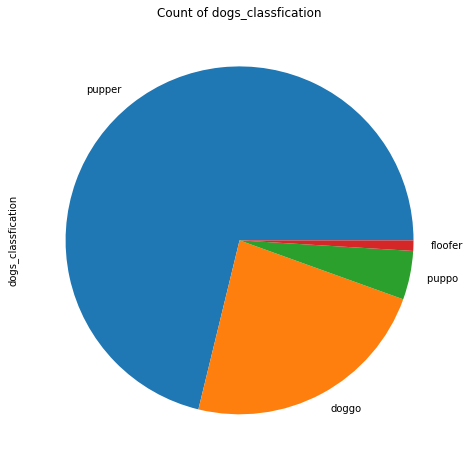

In [245]:
pie=data_merge[data_merge.dogs_classfication !='NaN']
pie.dogs_classfication.value_counts().plot(kind='pie',figsize=(8,8));
plt.title('Count of dogs_classfication');

insights
* pupper has the higher percantage than other classfications 

Avg favorite per dogs_classfication

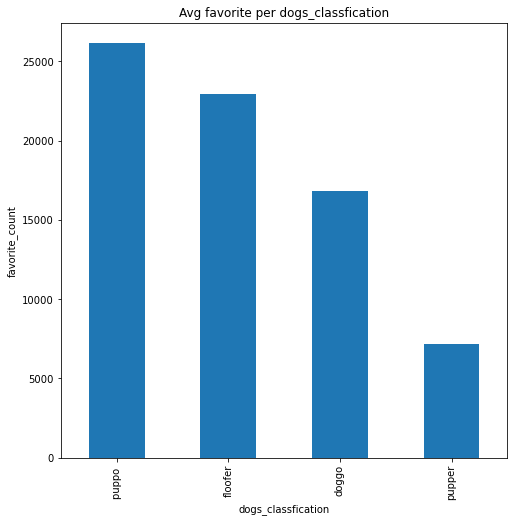

In [246]:
data_merge.groupby(['dogs_classfication']).favorite_count.mean().sort_values(ascending=False).plot(kind='bar',title='Avg favorite per dogs_classfication',figsize=(8,8));
plt.xlabel('dogs_classfication')
plt.ylabel('favorite_count');

insight 
puppo has higher favourit count 

relation between retweet count and favourit count 

Text(0, 0.5, 'favorite_count')

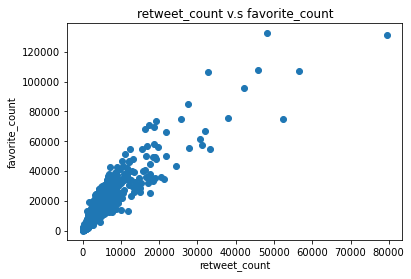

In [250]:
plt.scatter(data_merge.retweet_count , data_merge.favorite_count)
plt.title('retweet_count v.s favorite_count')
plt.xlabel('retweet_count')
plt.ylabel('favorite_count')

insight
we have positive relation between retweet count and favourit count as we can see

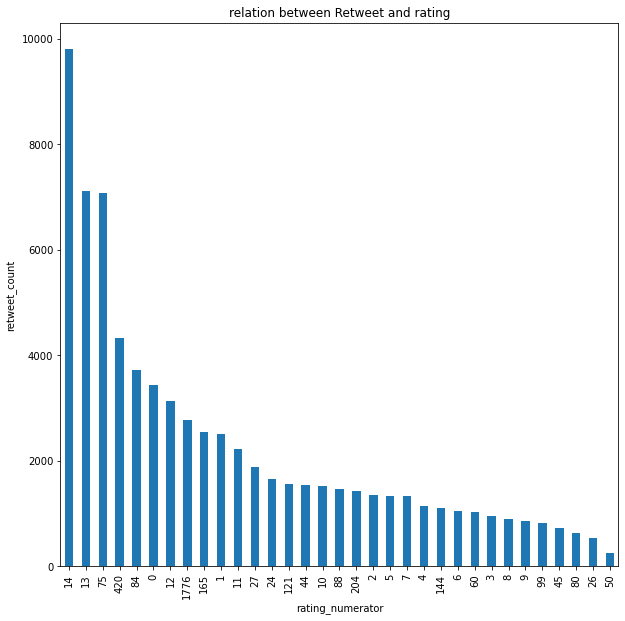

In [251]:
data_merge.groupby(['rating_numerator']).retweet_count.mean().sort_values(ascending=False).plot(kind='bar',title='relation between Retweet and rating',figsize=(10,10));

plt.xlabel('rating_numerator')
plt.ylabel('retweet_count');

insight
we can see that high retweet for numerator 14 & 13 